In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, \
confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

In [ ]:
# IMPORTANDO DATASET
uploaded = files.upload()

Saving winequalityN.csv to winequalityN.csv


In [ ]:
# CARREGAR DADOS
file_path = "winequalityN.csv"
df = pd.read_csv(file_path)

In [ ]:
# COLUNA 'QUALITY' PARA APLICAR REGRAS ESTIPULADAS
df['opinion'] = df['quality'].copy().apply(lambda row: 1 if row <= 5 else 0)

In [ ]:
# REMOVER 'QUALITY'
df = df.drop(columns='quality')

Quais são as variáveis?
Quais são os tipos de variáveis (discreta, categórica, contínua)?
Quais são as médias e desvios padrões?

In [ ]:
# Classificar as variáveis
variable_types = df.dtypes
categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()
continuous_vars = df.select_dtypes(include=['number']).columns.tolist()

In [ ]:
# Calcular médias e desvios padrões para variáveis contínuas
stats = df[continuous_vars].agg(['mean', 'std'])

In [ ]:
# RESULTADOS
print("Tipos de Variáveis:")
print(variable_types)
print("\nVariáveis Categóricas:", categorical_vars)
print("\nVariáveis Contínuas:", continuous_vars)
print("\nMédias e Desvios Padrões:")
print(stats)

Tipos de Variáveis:
type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
opinion                   int64
dtype: object

Variáveis Categóricas: ['type']

Variáveis Contínuas: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'opinion']

Médias e Desvios Padrões:
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
mean       7.216579          0.339691     0.318722        5.444326   0.056042   
std        1.296750          0.164649     0.145265        4.758125   0.035036   

      free sulfur dioxide  total sulfur d

In [ ]:
# SEPARAR VINHOS BRANCOS DOS TINTOS
red = df['type'] == 'red'
white = df['type'] == 'white'

In [ ]:
# BASE DE DADOS
def check(df):
    l = []
    colunas = df.columns

    for col in colunas:
        dtypes = df[col].dtypes
        nunique = df[col].nunique()
        sum_null = df[col].isnull().sum()

In [ ]:
# CALCULO E FREQUÊNCIA DA MODA
def check(df):
    l = []
    colunas = df.columns

    for col in colunas:
        dtypes = df[col].dtypes
        nunique = df[col].nunique()
        sum_null = df[col].isnull().sum()

        moda = df[col].mode().iloc[0] if not df[col].mode().empty else 'n/a'
        moda_freq = df[col].value_counts().iloc[0] if not df[col].value_counts().empty else 'n/a'

        if np.issubdtype(dtypes, np.number):
            status = df.describe(include='all').T
            media = status.loc[col, 'mean']
            std = status.loc[col, 'std']
            min_val = status.loc[col, 'min']
            quar1 = status.loc[col, '25%']
            median = df[col].median()
            quar3 = status.loc[col, '75%']
            max_val = status.loc[col, 'max']

        else:
            # definir 'n/a' de 'não se aplica'
            status = media = std = min_val = quar1 = median = quar3 = max_val = 'n/a'

        l.append([col, dtypes, nunique, sum_null, media, std, min_val, quar1, median, quar3, max_val, moda, moda_freq])

        df_check = pd.DataFrame(l)
    df_check.columns = ['coluna', 'tipo', 'únicos', 'null_soma', 'media', 'desvio',
                        'minimo', '25%', 'mediana', '75%', 'maximo', 'moda', 'frequência_moda']

In [ ]:
def shape(white_df, red_df):

    def get_info(df):
        return {
            "Total Linhas": df.shape[0],
            "Linhas Únicas": len(df) - df.duplicated().sum(),
            "Linhas Duplicadas": df.duplicated().sum(),
            "Linhas com Nulos": df.isnull().any(axis=1).sum(),
            "": "",
            "Total Colunas": df.shape[1],
            "Int64": sum(df.dtypes == "int64"),
            "Float64": sum(df.dtypes == "float64"),
            "Object": sum(df.dtypes == "object")
        }

    # DATASET DOS VINHOS BRANCOS E TINTOS
    summary_df = pd.DataFrame({
        "White": get_info(white_df),
        "Red": get_info(red_df)
    })

    return summary_df

In [ ]:
# DADOS VINHOS BRANCOS E TINTOS
shape(df[white], df[red])

,White,Red
Total Linhas,4898,1599
Linhas Únicas,3970,1359
Linhas Duplicadas,928,240
Linhas com Nulos,28,6
,,
Total Colunas,13,13
Int64,1,1
Float64,11,11
Object,1,1


In [ ]:
# REMOVER DUPLICADAS E TRANSFORMAR BRANCO E TINTO EM DATASET
white = df[df.type == 'white'].drop_duplicates()
red = df[df.type == 'red'].drop_duplicates()

In [ ]:
# GRÁFICO CADA TIPO DE VINHO ( TINTO OU BRANCO )
def plot_boxplots(data, title):
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # GRÁFICO
    fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 10))
    fig.suptitle(f"Distribuição Dinâmica das Variáveis - {title}", fontsize=16)

    axes = axes.flatten()

    # BOXPLOTS PARA CADA VARIÁVEL
    for i, column in enumerate(numeric_columns):
        sns.boxplot(data=data, y=column, ax=axes[i], color='gray')
        axes[i].set_title(column, fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    plt.subplots_adjust(hspace=0.3, wspace=0.4)

    # GRÁFICO
    plt.show()

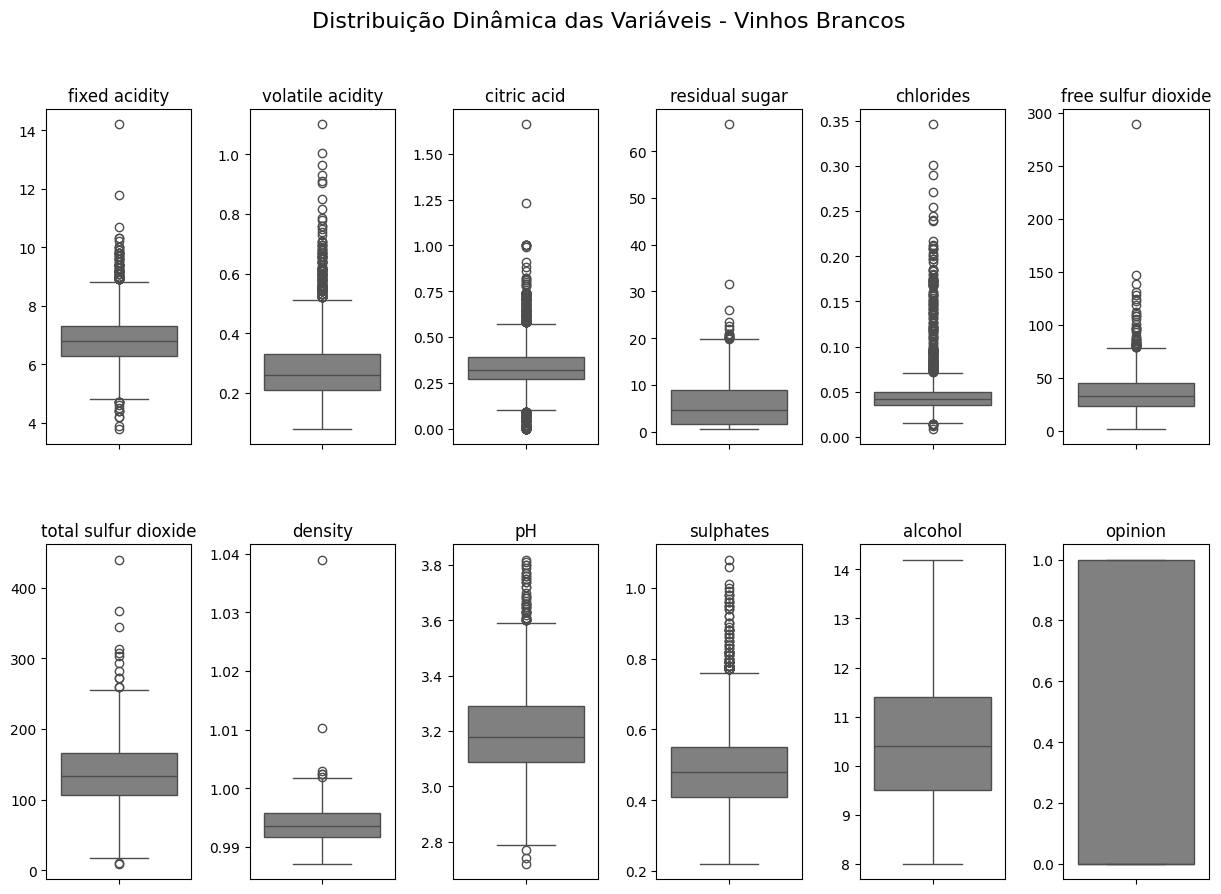

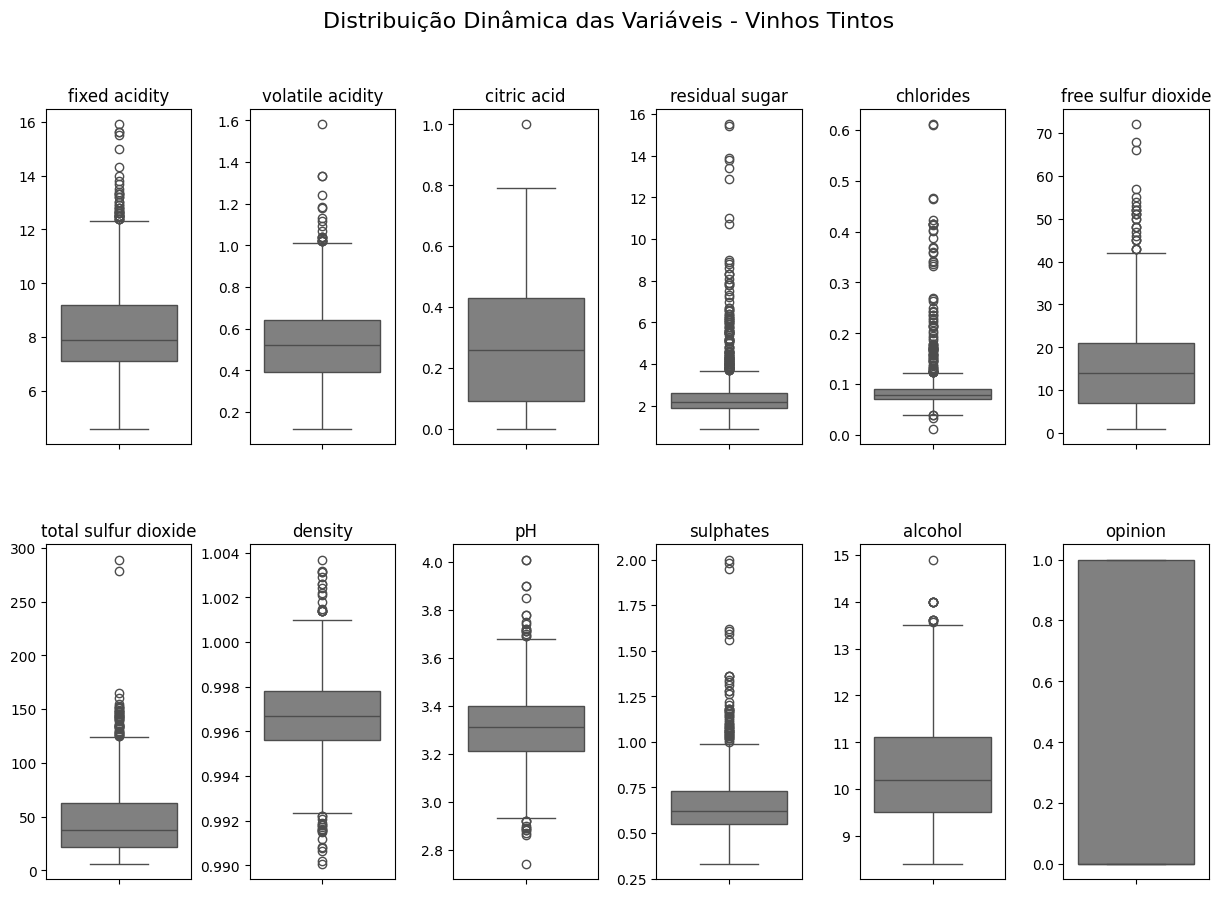

In [ ]:
# GRÁFICO VINHO BRANCO E TINTOS
plot_boxplots(white, "Vinhos Brancos")
plot_boxplots(red, "Vinhos Tintos")

In [ ]:
# HISTOGRAMA
def plot_histograms(data, title):
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(13, 11))
    fig.suptitle(f"Análise da Faixa Dinâmica das Variáveis - {title}", fontsize=16)

    axes = axes.flatten()

    # HISTOGRAMA PARA CADA VARIÁVEL
    for i, col in enumerate(numeric_columns):
        sns.histplot(data=data, x=col, color='gray', kde=True, ax=axes[i])

        axes[i].set_title(col, fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].grid(True, alpha=0.8)

        max_y = data[col].value_counts().max()
        axes[i].set_ylim(0, max_y + max_y * 0.1)

        plt.subplots_adjust(hspace=0.3, wspace=0.2)

    # GRÁFICO
    plt.show()

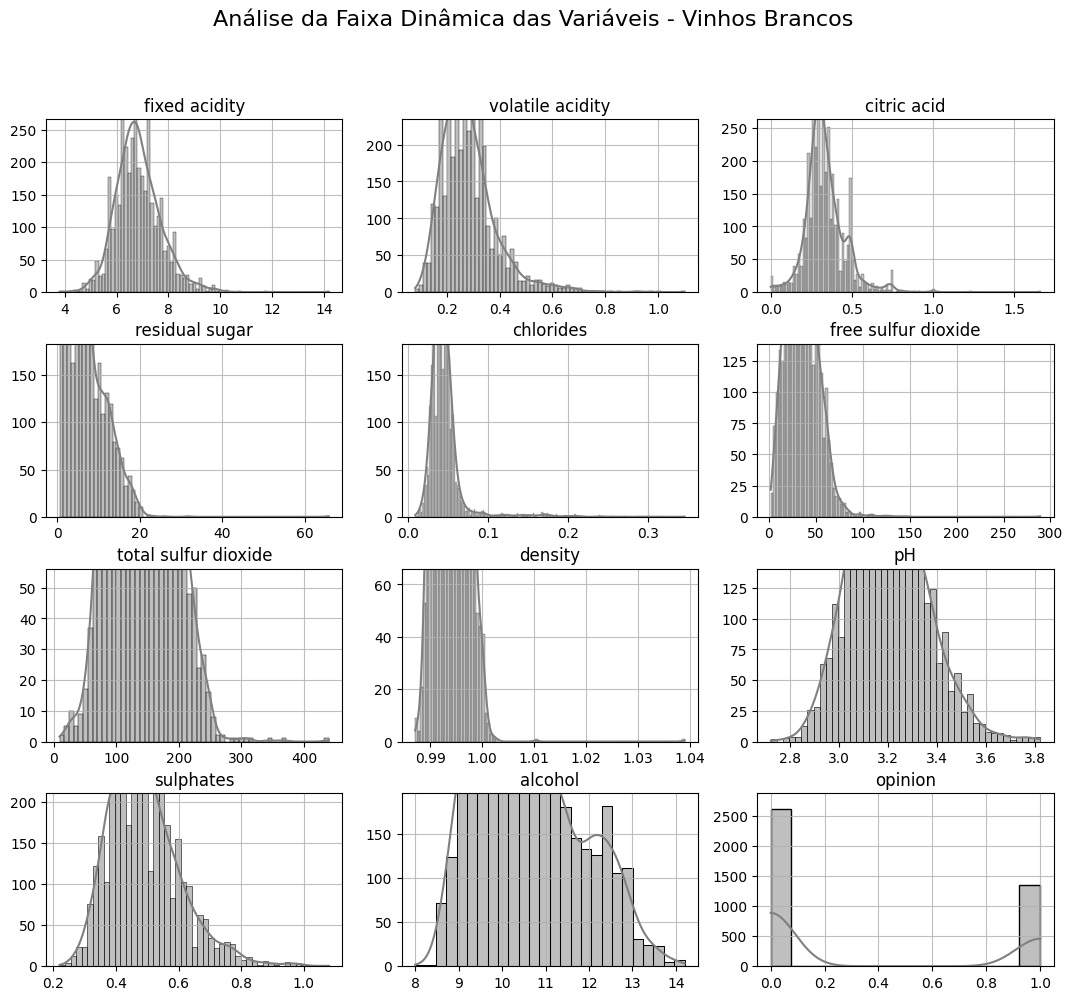

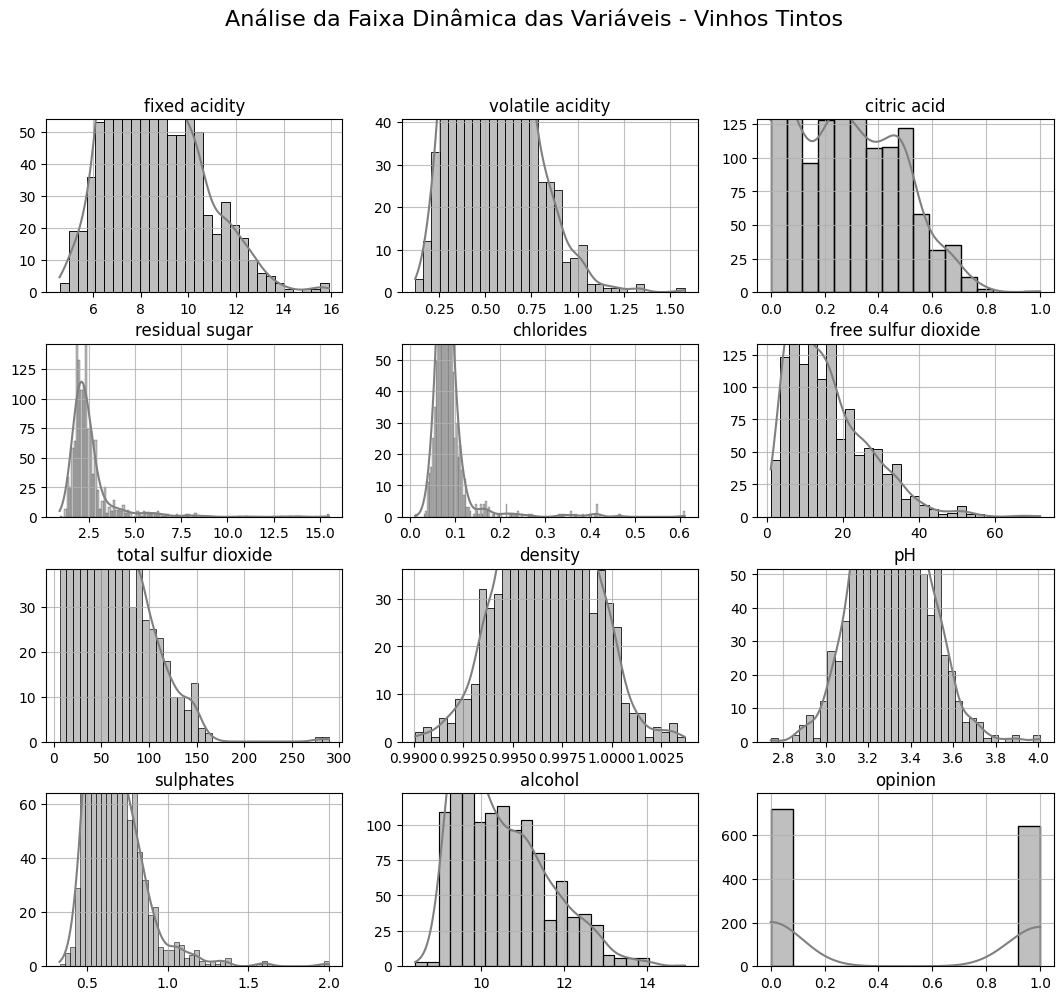

In [ ]:
# GRÁFICO VINHO BRANCO E TINTO
plot_histograms(white, "Vinhos Brancos")
plot_histograms(red, "Vinhos Tintos")

In [ ]:
# DADOS NULOS
def fill_missing_values(df, tol=0.1):
    # COLUNA NUMÉRICA
    for col in df.select_dtypes(include=["float64", "int64"]).columns:
        mean_val = df[col].mean()
        median_val = df[col].median()

        # COLUNAS COM DADOS NULOS
        if df[col].isnull().sum() > 0:

            # MÉDIA
            if abs(mean_val - median_val) <= (tol * median_val):
                df[col].fillna(mean_val, inplace=True)

            # MEDIANA
            else:
                df[col].fillna(median_val, inplace=True)

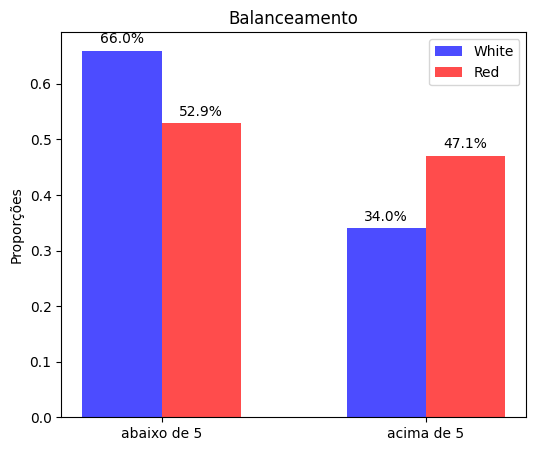

In [ ]:
# BALANCEAMENTO
proportions_white = white['opinion'].value_counts(normalize=True)
proportions_red = red['opinion'].value_counts(normalize=True)

labels = ['abaixo de 5', 'acima de 5']
x = np.arange(len(labels))

width = 0.30

# GRAFICO COM OS 2 VINHOS ( BRANCO E TINTO )
fig, ax = plt.subplots(figsize=(6,5))
bars_white = ax.bar(x - width/2, proportions_white.sort_index(), width, label='White', color='blue', alpha=0.7)
bars_red = ax.bar(x + width/2, proportions_red.sort_index(), width, label='Red', color='red', alpha=0.7)

# % NOS DADOS
for bars in [bars_white, bars_red]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='black')

# NOMEAR
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Proporções')
ax.set_title('Balanceamento')
ax.legend()

plt.show()

In [ ]:
white.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'opinion'],
      dtype='object')

In [ ]:
# DEFINIX X DATASET
white_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
                  'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

X_white = white[white_features]

In [ ]:
# DEFINIR 'target predict' OU Y
y_white = white['opinion']

In [ ]:
# SEPARAR TREINO E TESTE
X_train, X_test, y_train, y_test = train_test_split(X_white, y_white, test_size=0.2, random_state=17, shuffle=True, stratify=y_white)

In [ ]:
# NORMALIZAÇÃO
r_scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True)

In [ ]:
# FIT DOS DATASETS TREINO
r_scaler.fit(X_train)

RobustScaler()

In [ ]:
# TRENO E TESTE
X_train_scaled = r_scaler.transform(X_train)
X_test_scaled = r_scaler.transform(X_test)

In [ ]:
# K-Fold estratificado
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)

# MÉTRICAS PARA CADA MODELO
results = {}

In [ ]:
# HIPERPARÂMETRO PARA O GRID SEARCH
rl_param_grid = {
                'penalty': ['l2', 'elasticnet', None],
                'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                'multi_class': ['ovr', 'multinomial'],
                'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'l1_ratio': [None, 0, 1]
                }

In [ ]:
# MODELO DE REGRESSÃO LOGÍSTICA PARA O GRID SEARCH
rl_model = LogisticRegression(dual=False, tol=0.0001, fit_intercept=True, intercept_scaling=1.0, class_weight='balanced', random_state=17, max_iter=1000, verbose=0, warm_start=False, n_jobs=None)

In [ ]:
# GRID SEARCH COM VALIDAÇÃO CRUZADA
rl_grid_search = GridSearchCV(rl_model, rl_param_grid, cv=kf, scoring='f1_macro', n_jobs=-1, refit=True)

In [ ]:
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [ ]:
param_grid = {
    "penalty": ["l1", "l2", "elasticnet"],
    "solver": ["saga"],
    "l1_ratio": [0.1, 0.5, 0.9]
}

In [ ]:
# MELHOR HIPERPARÂMETRO
rl_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
2460 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_s

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=17, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          intercept_scaling=1.0, max_iter=1000,
                                          random_state=17),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [None, 0, 1],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='f1_macro')

In [ ]:
# 10 MELHORES
rl_mean_scores = np.nan_to_num(rl_grid_search.cv_results_['mean_test_score'])
rl_params = rl_grid_search.cv_results_['params']

rl_top_10 = rl_mean_scores.argsort()[::-1][:10]

rl_top_10_df = [
                {**rl_params[idx], "score": rl_mean_scores[idx]} for idx in rl_top_10
            ]

rl_top_10_df = pd.DataFrame(rl_top_10_df)

print("Modelos de combinações de hiperparâmetros:")
rl_top_10_df

Modelos de combinações de hiperparâmetros:


,C,l1_ratio,multi_class,penalty,solver,score
0,100.00,NaN,multinomial,l2,lbfgs,0.711604
1,100.00,0.0,multinomial,l2,lbfgs,0.711604
2,100.00,1.0,multinomial,l2,lbfgs,0.711604
3,100.00,1.0,ovr,l2,newton-cholesky,0.711321
4,100.00,0.0,ovr,l2,newton-cholesky,0.711321
5,100.00,NaN,ovr,l2,newton-cholesky,0.711321
6,0.01,1.0,multinomial,None,lbfgs,0.711223
7,10.00,0.0,multinomial,None,lbfgs,0.711223
8,0.10,1.0,multinomial,None,lbfgs,0.711223
9,1.00,0.0,multinomial,None,lbfgs,0.711223


In [ ]:
# MELHOR PARÂMETRO
rl_best_params = pd.DataFrame([{**rl_grid_search.best_params_, 'score': rl_grid_search.best_score_}])

rl_best_params

,C,l1_ratio,multi_class,penalty,solver,score
0,100,None,multinomial,l2,lbfgs,0.711604


In [ ]:
# MODELO GRID SEARCH ENCONTRADO
rl_best_model = rl_grid_search.best_estimator_

In [ ]:
# MÉTRICA NA VALIDAÇÃO CRUZADA
def compute_metrics(modelo, X, y, kf):
    metrics = {
        'accuracy': cross_val_score(modelo, X, y, cv=kf, scoring='accuracy'),
        'precision': cross_val_score(modelo, X, y, cv=kf, scoring='precision'),
        'recall': cross_val_score(modelo, X, y, cv=kf, scoring='recall'),
        'f1': cross_val_score(modelo, X, y, cv=kf, scoring='f1')
    }
    return metrics

In [ ]:
# MÉTRICA PARA MELHOR MODELO
rl_best_metrics_train = compute_metrics(rl_best_model, X_train, y_train, kf)
rl_best_metrics_test = compute_metrics(rl_best_model, X_test, y_test, kf)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

In [ ]:
# TREINO
metrics_list = ['accuracy', 'precision', 'recall', 'f1']

rl_metrics_train_df = pd.DataFrame({
    'Mínimo': [rl_best_metrics_train[m].min() for m in metrics_list],
    'Média': [rl_best_metrics_train[m].mean() for m in metrics_list],
    'Máximo': [rl_best_metrics_train[m].max() for m in metrics_list],
    'Desvio Padrão': [rl_best_metrics_train[m].std() for m in metrics_list]
}, index=['Acurácia', 'Precisão', 'Recall', 'F1-Score'])

In [ ]:
# TESTE
rl_metrics_test_df = pd.DataFrame({
    'Mínimo': [rl_best_metrics_test[m].min() for m in metrics_list],
    'Média': [rl_best_metrics_test[m].mean() for m in metrics_list],
    'Máximo': [rl_best_metrics_test[m].max() for m in metrics_list],
    'Desvio Padrão': [rl_best_metrics_test[m].std() for m in metrics_list]
}, index=['Acurácia', 'Precisão', 'Recall', 'F1-Score'])

In [ ]:
# RESULTADO TREINO
print('Métricas para Regressão Logística - Treino')
rl_metrics_train_df

Métricas para Regressão Logística - Treino


,Mínimo,Média,Máximo,Desvio Padrão
Acurácia,0.687697,0.726381,0.769716,0.023891
Precisão,0.532374,0.576773,0.620690,0.026931
Recall,0.666667,0.736366,0.833333,0.048445
F1-Score,0.599190,0.646546,0.711462,0.033175


In [ ]:
# RESULTADO TESTE
print('Métricas para Regressão Logística - Teste')
rl_metrics_test_df

Métricas para Regressão Logística - Teste


,Mínimo,Média,Máximo,Desvio Padrão
Acurácia,0.632911,0.714177,0.835443,0.054636
Precisão,0.473684,0.566362,0.750000,0.074218
Recall,0.555556,0.733333,0.814815,0.071817
F1-Score,0.526316,0.636801,0.763636,0.063068


In [ ]:
# HIPEPARÂMETRO PARA O DRIG SEARCH
tree_param_grid = {
                    'criterion': ['gini', 'entropy', 'log_loss'],
                    'splitter': ['best', 'random'],
                    'max_depth': range(2, 11),
                    'min_samples_split': [2, 3, 4, 5, 10],
                    'min_samples_leaf': [1, 2, 5],
                    'max_features': [None, 'auto', 'sqrt', 'log2']
                    }

In [ ]:
# ÁRVORE DE DECISÃO
tree_model = DecisionTreeClassifier(min_weight_fraction_leaf = 0.0, random_state = 17, max_leaf_nodes = None, min_impurity_decrease = 0.0, class_weight = None, ccp_alpha = 0.0)

In [ ]:
# GRID SEARCH COM VALIDAÇÃO CRUZADA ESTRATIFICADA
tree_grid_search = GridSearchCV(tree_model, tree_param_grid, cv=kf, scoring='f1_macro', n_jobs=-1)

In [ ]:
# TREINAR ÁRVORE DE DECISÃO E MELHOR HIPERPARÂMETRO
tree_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
8100 fits failed out of a total of 32400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=17, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(2, 11),
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 3, 4, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='f1_macro')

In [ ]:
# 10 MELHORES
tree_mean_scores = np.nan_to_num(tree_grid_search.cv_results_['mean_test_score'])
tree_params = tree_grid_search.cv_results_['params']

tree_top_10 = tree_mean_scores.argsort()[::-1][:10]

tree_top_10_df = [
                {**tree_params[idx], "score": tree_mean_scores[idx]} for idx in tree_top_10
            ]

tree_top_10_df = pd.DataFrame(tree_top_10_df)

print("Modelos de combinações de hiperparâmetros:")
tree_top_10_df

Modelos de combinações de hiperparâmetros:


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,score
0,gini,6,None,5,5,best,0.713644
1,gini,6,None,5,2,best,0.713644
2,gini,6,None,5,3,best,0.713644
3,gini,6,None,5,4,best,0.713644
4,gini,6,None,5,10,best,0.713644
5,gini,6,None,1,10,best,0.713347
6,gini,6,None,1,2,best,0.713334
7,gini,6,None,1,3,best,0.713334
8,gini,6,None,1,5,best,0.713161
9,gini,6,None,1,4,best,0.712871


In [ ]:
# MELHOR COMBINAÇÃO DE PARÂMETRO
tree_best_params = pd.DataFrame([{**tree_grid_search.best_params_, 'score': tree_grid_search.best_score_}])

tree_best_params

,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,score
0,gini,6,None,5,2,best,0.713644


In [ ]:
# MODELO ENCONTRO PELO GRID SEARCH
tree_best_model = tree_grid_search.best_estimator_

In [ ]:
# MÉTRICA PARA MODELOS
tree_best_metrics_train = compute_metrics(tree_best_model, X_train, y_train, kf)
tree_best_metrics_test = compute_metrics(tree_best_model, X_test, y_test, kf)

In [ ]:
# RESULTADO TREINO
metrics_list = ['accuracy', 'precision', 'recall', 'f1']

tree_metrics_train_df = pd.DataFrame({
    'Mínimo': [tree_best_metrics_train[m].min() for m in metrics_list],
    'Média': [tree_best_metrics_train[m].mean() for m in metrics_list],
    'Máximo': [tree_best_metrics_train[m].max() for m in metrics_list],
    'Desvio Padrão': [tree_best_metrics_train[m].std() for m in metrics_list]
}, index=['Acurácia', 'Precisão', 'Recall', 'F1-Score'])

In [ ]:
# RESULTADO TESTE
tree_metrics_test_df = pd.DataFrame({
    'Mínimo': [tree_best_metrics_test[m].min() for m in metrics_list],
    'Média': [tree_best_metrics_test[m].mean() for m in metrics_list],
    'Máximo': [tree_best_metrics_test[m].max() for m in metrics_list],
    'Desvio Padrão': [tree_best_metrics_test[m].std() for m in metrics_list],
}, index=['Acurácia', 'Precisão', 'Recall', 'F1-Score'])

In [ ]:
# RESULTADO TREINO
print('Métricas para Árvore de Decisão - Treino')
tree_metrics_train_df

Métricas para Árvore de Decisão - Treino


,Mínimo,Média,Máximo,Desvio Padrão
Acurácia,0.712934,0.748105,0.776025,0.016703
Precisão,0.577982,0.642902,0.703297,0.033277
Recall,0.495413,0.592134,0.657407,0.048479
F1-Score,0.571429,0.614728,0.648148,0.028293


In [ ]:
# RESULTADO TESTE
print('Métricas para Árvore de Decisão - Teste')
tree_metrics_test_df

Métricas para Árvore de Decisão - Teste


,Mínimo,Média,Máximo,Desvio Padrão
Acurácia,0.620253,0.696519,0.787500,0.061565
Precisão,0.440000,0.563167,0.800000,0.112441
Recall,0.407407,0.555556,0.777778,0.120584
F1-Score,0.423077,0.552290,0.701754,0.091392


In [ ]:
# DIMENSÕES DA ÁRVORE
print(f'Profundidade: {tree_best_model.get_depth()}')
print(f'nós: {tree_best_model.get_n_leaves()}')

Profundidade: 6
nós: 51


In [ ]:
# SVM
svm_param_grid = {
                'C': list(np.arange(1.0, 10.2, 0.1)),
                'degree': [2, 3, 4],  # apenas para o kernel='poly'
                'gamma': ['scale', 'auto'],
                'shrinking': [True, False]
                }

In [ ]:
# SVM
svm_model = SVC(kernel='rbf', coef0=0, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=1000, decision_function_shape='ovr', break_ties=False, random_state=None)

In [ ]:
# VALIDAÇÃO CRUZADA ESTRATIFICADA ( SVM )
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=kf, scoring='f1_macro', n_jobs=-1)

In [ ]:
# treinar o modelo e buscando os melhores hiperparâmetros
svm_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=17, shuffle=True),
             estimator=SVC(coef0=0, max_iter=1000, probability=True), n_jobs=-1,
             param_grid={'C': [1.0, 1.1, 1.2000000000000002, 1.3000000000000003,
                               1.4000000000000004, 1.5000000000000004,
                               1.6000000000000005, 1.7000000000000006,
                               1.8000000000000007, 1.9000000000000008,
                               2.000000000000001, 2.100000000000001...
                               2.6000000000000014, 2.7000000000000015,
                               2.8000000000000016, 2.9000000000000017,
                               3.0000000000000018, 3.100000000000002,
                               3.200000000000002, 3.300000000000002,
                               3.400000000000002, 3.500000000000002,
                               3.6000000000000023, 3.7000000000000024,
                               3.8000000000000025, 3.9000000000000026, ...],
                         'degree': [2, 3, 4], 'gamma': ['scale', 'auto'],
                         'shrinking': [True, False]},
             scoring='f1_macro')

In [ ]:
# 10 MELHORES
svm_mean_scores = np.nan_to_num(svm_grid_search.cv_results_['mean_test_score'])
svm_params = svm_grid_search.cv_results_['params']

svm_top_10 = svm_mean_scores.argsort()[::-1][:10]

svm_top_10_df = [
                {**svm_params[idx], "score": svm_mean_scores[idx]} for idx in svm_top_10
            ]

svm_top_10_df = pd.DataFrame(svm_top_10_df)

print("Modelos combinações de hiperparâmetros:")
svm_top_10_df


Modelos combinações de hiperparâmetros:


,C,degree,gamma,shrinking,score
0,10.0,3,scale,False,0.633649
1,10.0,2,scale,False,0.633649
2,10.0,3,scale,True,0.633649
3,10.0,4,scale,True,0.633649
4,10.0,4,scale,False,0.633649
5,10.0,2,scale,True,0.633649
6,9.7,4,scale,False,0.628804
7,9.7,2,scale,False,0.628804
8,9.7,3,scale,True,0.628804
9,9.7,3,scale,False,0.628804


In [ ]:
# PARÂMETRO
svm_best_params = pd.DataFrame([{**svm_grid_search.best_params_, 'score': svm_grid_search.best_score_}])

svm_best_params

,C,degree,gamma,shrinking,score
0,10.0,2,scale,True,0.633649


In [ ]:
# MELHOR MODELO PELO GRID SEARCH
svm_best_model = svm_grid_search.best_estimator_

In [ ]:
# MÉTRICAS PARA MELHOR MODELO
svm_best_metrics_train = compute_metrics(svm_best_model, X_train, y_train, kf)
svm_best_metrics_test = compute_metrics(svm_best_model, X_test, y_test, kf)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider

In [ ]:
# TREINO
metrics_list = ['accuracy', 'precision', 'recall', 'f1']

svm_metrics_train_df = pd.DataFrame({
    'Mínimo': [svm_best_metrics_train[m].min() for m in metrics_list],
    'Média': [svm_best_metrics_train[m].mean() for m in metrics_list],
    'Máximo': [svm_best_metrics_train[m].max() for m in metrics_list],
    'Desvio Padrão': [svm_best_metrics_train[m].std() for m in metrics_list]
}, index=['Acurácia', 'Precisão', 'Recall', 'F1-Score'])

In [ ]:
# TESTE
svm_metrics_test_df = pd.DataFrame({
    'Mínimo': [svm_best_metrics_test[m].min() for m in metrics_list],
    'Média': [svm_best_metrics_test[m].mean() for m in metrics_list],
    'Máximo': [svm_best_metrics_test[m].max() for m in metrics_list],
    'Desvio Padrão': [svm_best_metrics_test[m].std() for m in metrics_list]
}, index=['Acurácia', 'Precisão', 'Recall', 'F1-Score'])

In [ ]:
# RESULTADO TREINO
print('Métricas para Máquinas Suportadas por Vetores - Treino')
svm_metrics_train_df

Métricas para Máquinas Suportadas por Vetores - Treino


,Mínimo,Média,Máximo,Desvio Padrão
Acurácia,0.669811,0.694591,0.712934,0.013573
Precisão,0.515464,0.573941,0.644068,0.036439
Recall,0.305556,0.428228,0.527778,0.067686
F1-Score,0.402439,0.485445,0.553398,0.039253


In [ ]:
# RESULTADO TESTE
print('Métricas para Máquinas Suportadas por Vetores - Teste')
svm_metrics_test_df

Métricas para Máquinas Suportadas por Vetores - Teste


,Mínimo,Média,Máximo,Desvio Padrão
Acurácia,0.625000,0.670079,0.721519,0.030155
Precisão,0.285714,0.601944,1.000000,0.229482
Recall,0.074074,0.129630,0.185185,0.037952
F1-Score,0.117647,0.210858,0.312500,0.061615


In [ ]:
# MELHORES PARÂMETROS
best_models = {
    "Regressão Logística": rl_best_model,
    "Árvore de Decisão": tree_best_model,
    "SVM": svm_best_model
}

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

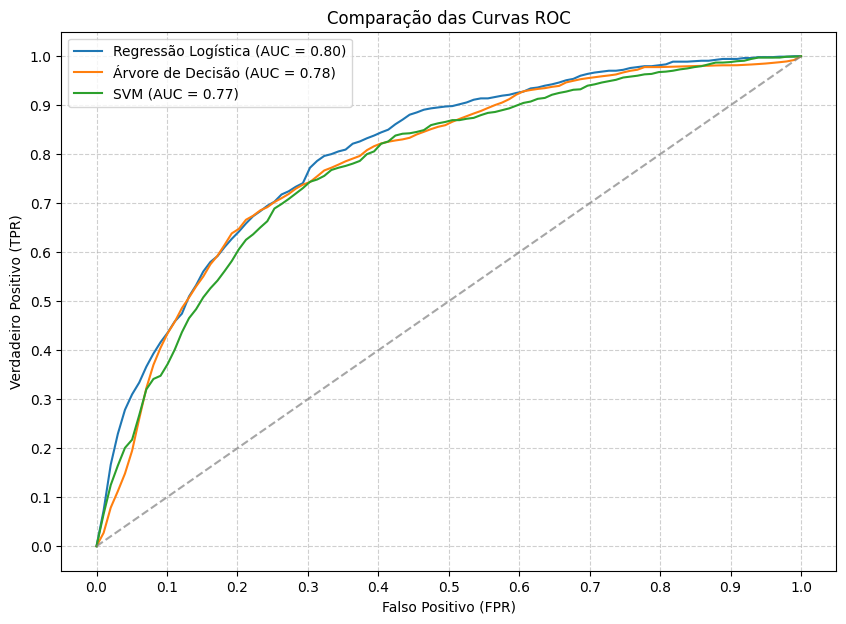

In [ ]:
# AUC DE CADA MODELO
auc_scores = {}

plt.figure(figsize=(10, 7))

# CURVA ROC
for name, model in best_models.items():
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    # VALIDAÇÃO CRUZADA
    # Impute missing values in X_train_scaled before prediction
    imputer = SimpleImputer(strategy='mean')  # or other strategy
    X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)

    y_scores = cross_val_predict(model, X_train_scaled_imputed, y_train, cv=kf, method='predict_proba')[:, 1]

    # CURVA ROC
    fpr, tpr, _ = roc_curve(y_train, y_scores)
    auc_value = auc(fpr, tpr)

    # AUC NO DICIONÁRIO
    auc_scores[name] = auc_value

    # CURVAS ROC PARA SUAVIZAÇÃO
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(auc_value)

    # MÉDIAS CURVA ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)

    plt.plot(mean_fpr, mean_tpr, label=f"{name} (AUC = {mean_auc:.2f})")

# LINHA DE REFERÊNCIA
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.title("Comparação das Curvas ROC")
plt.legend(loc='best')
plt.show()

In [ ]:
# DICIONÁRIO MÉTRICA TREINO
test_metrics_dict = {
                'Modelo': ['Regressão Logística', 'Árvore de Decisão', 'SVM'],
                'Acurácia': [rl_metrics_train_df.loc['Acurácia', 'Média'],
                            tree_metrics_train_df.loc['Acurácia', 'Média'],
                            svm_metrics_train_df.loc['Acurácia', 'Média']],
                'Precisão': [rl_metrics_train_df.loc['Precisão', 'Média'],
                            tree_metrics_train_df.loc['Precisão', 'Média'],
                            svm_metrics_train_df.loc['Precisão', 'Média']],
                'Recall': [rl_metrics_train_df.loc['Recall', 'Média'],
                        tree_metrics_train_df.loc['Recall', 'Média'],
                        svm_metrics_train_df.loc['Recall', 'Média']],
                'F1-Score': [rl_metrics_train_df.loc['F1-Score', 'Média'],
                            tree_metrics_train_df.loc['F1-Score', 'Média'],
                            svm_metrics_train_df.loc['F1-Score', 'Média']],
                'AUC': [auc_scores['Regressão Logística'],
                        auc_scores['Árvore de Decisão'],
                        auc_scores['SVM']]
            }

In [ ]:
# DICIONÁRIO MÉTRICA TESTE
train_metrics_dict = {
                'Modelo': ['Regressão Logística', 'Árvore de Decisão', 'SVM'],
                'Acurácia': [rl_metrics_test_df.loc['Acurácia', 'Média'],
                            tree_metrics_test_df.loc['Acurácia', 'Média'],
                            svm_metrics_test_df.loc['Acurácia', 'Média']],
                'Precisão': [rl_metrics_test_df.loc['Precisão', 'Média'],
                            tree_metrics_test_df.loc['Precisão', 'Média'],
                            svm_metrics_test_df.loc['Precisão', 'Média']],
                'Recall': [rl_metrics_test_df.loc['Recall', 'Média'],
                        tree_metrics_test_df.loc['Recall', 'Média'],
                        svm_metrics_test_df.loc['Recall', 'Média']],
                'F1-Score': [rl_metrics_test_df.loc['F1-Score', 'Média'],
                            tree_metrics_test_df.loc['F1-Score', 'Média'],
                            svm_metrics_test_df.loc['F1-Score', 'Média']],
                'AUC': [auc_scores['Regressão Logística'],
                        auc_scores['Árvore de Decisão'],
                        auc_scores['SVM']]
            }

In [ ]:
# CRIAR DATASET
all_train_metrics_df = pd.DataFrame(train_metrics_dict)
all_test_metrics_df = pd.DataFrame(test_metrics_dict)

In [ ]:
# RESULTADO TREINO
print("Métricas de treino dos modelos")
all_train_metrics_df

Métricas de treino dos modelos


,Modelo,Acurácia,Precisão,Recall,F1-Score,AUC
0,Regressão Logística,0.714177,0.566362,0.733333,0.636801,0.802994
1,Árvore de Decisão,0.696519,0.563167,0.555556,0.552290,0.784532
2,SVM,0.670079,0.601944,0.129630,0.210858,0.774614


In [ ]:
# RESULTADO TESTE
print("Métricas de teste dos modelos")
all_test_metrics_df

Métricas de teste dos modelos


,Modelo,Acurácia,Precisão,Recall,F1-Score,AUC
0,Regressão Logística,0.726381,0.576773,0.736366,0.646546,0.802994
1,Árvore de Decisão,0.748105,0.642902,0.592134,0.614728,0.784532
2,SVM,0.694591,0.573941,0.428228,0.485445,0.774614


In [ ]:
# X PARA DATASET VINHO TINTO
red_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
                  'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

X_red = red[red_features]

In [ ]:
# DEFINIR 'target predict' OU Y
y_red = red['opinion']

In [ ]:
# TRANSFORMAR DADOS DE TESTE COM SCALER DE WHITE, JA TREINADO
X_red_scaled = r_scaler.transform(X_red)

In [ ]:
# FAZER INFERÊNCIA
imputer = SimpleImputer(strategy='mean')
X_red_scaled_imputed = imputer.fit_transform(X_red_scaled)
red_y_hat = rl_best_model.predict(X_red_scaled_imputed)

In [ ]:
# VINHOS BRANCOS PARA COMPARAÇÃO
print("Classificação para vinhos brancos:")
white_y_hat = rl_best_model.predict(X_test)
print(classification_report(y_test, white_y_hat))

Classificação para vinhos brancos:
              precision    recall  f1-score   support

           0       0.85      0.69      0.77       524
           1       0.57      0.77      0.65       270

    accuracy                           0.72       794
   macro avg       0.71      0.73      0.71       794
weighted avg       0.76      0.72      0.73       794



In [ ]:
# CLASSIFICAÇÃO DE VINHOS TINTOS
print("Classificação para vinhos tintos:")
print(classification_report(y_red, red_y_hat))

Classificação para vinhos tintos:
              precision    recall  f1-score   support

           0       0.80      0.01      0.01       719
           1       0.47      1.00      0.64       640

    accuracy                           0.47      1359
   macro avg       0.64      0.50      0.33      1359
weighted avg       0.65      0.47      0.31      1359



*CONCLUSÃO* :



Para criar um modelo de classificação, primeiro analisamos e tratamos os dados. Depois, definimos o problema, o alvo a ser previsto ('y') e escolhemos as colunas relevantes ('X') para treinar o modelo.

Dentre os modelos analisados, a Regressão Logística apresentou o melhor desempenho em termos de F1-score, sendo 63.68% no treino e 64.65% no teste. Além disso, sua AUC também se destacou como os melhores scores, sendo 80.30% no treino e 80.30% no teste. Esses resultados tornam a Regressão Logística a melhor escolha para uma eventual operação. O modelo classificou 640 vinhos como bons e 719 como ruins. Para comparação, os vinhos brancos foram classificados em 640 bons e 719 ruins. Além disso, o F1-score médio, que foi de 71% para os vinhos brancos, caiu para apenas 33% quando aplicado aos vinhos tintos.

A Regressão Linear prevê variáveis contínuas, enquanto a Regressão Logística trabalha com classificações (sim/não) usando probabilidades entre 0 e 1. A regressão linear gera uma relação reta, enquanto a logística produz uma curva sigmoide. Para evitar sobreajuste, a Validação Cruzada divide os dados em várias partes para treinar e testar o modelo repetidamente. O StratifiedKFold mantém a proporção das classes equilibrada, garantindo uma avaliação mais confiável em problemas desbalanceados.



FINALIZAÇÃO DO MÓDULO KAGGLE RELIZADO :
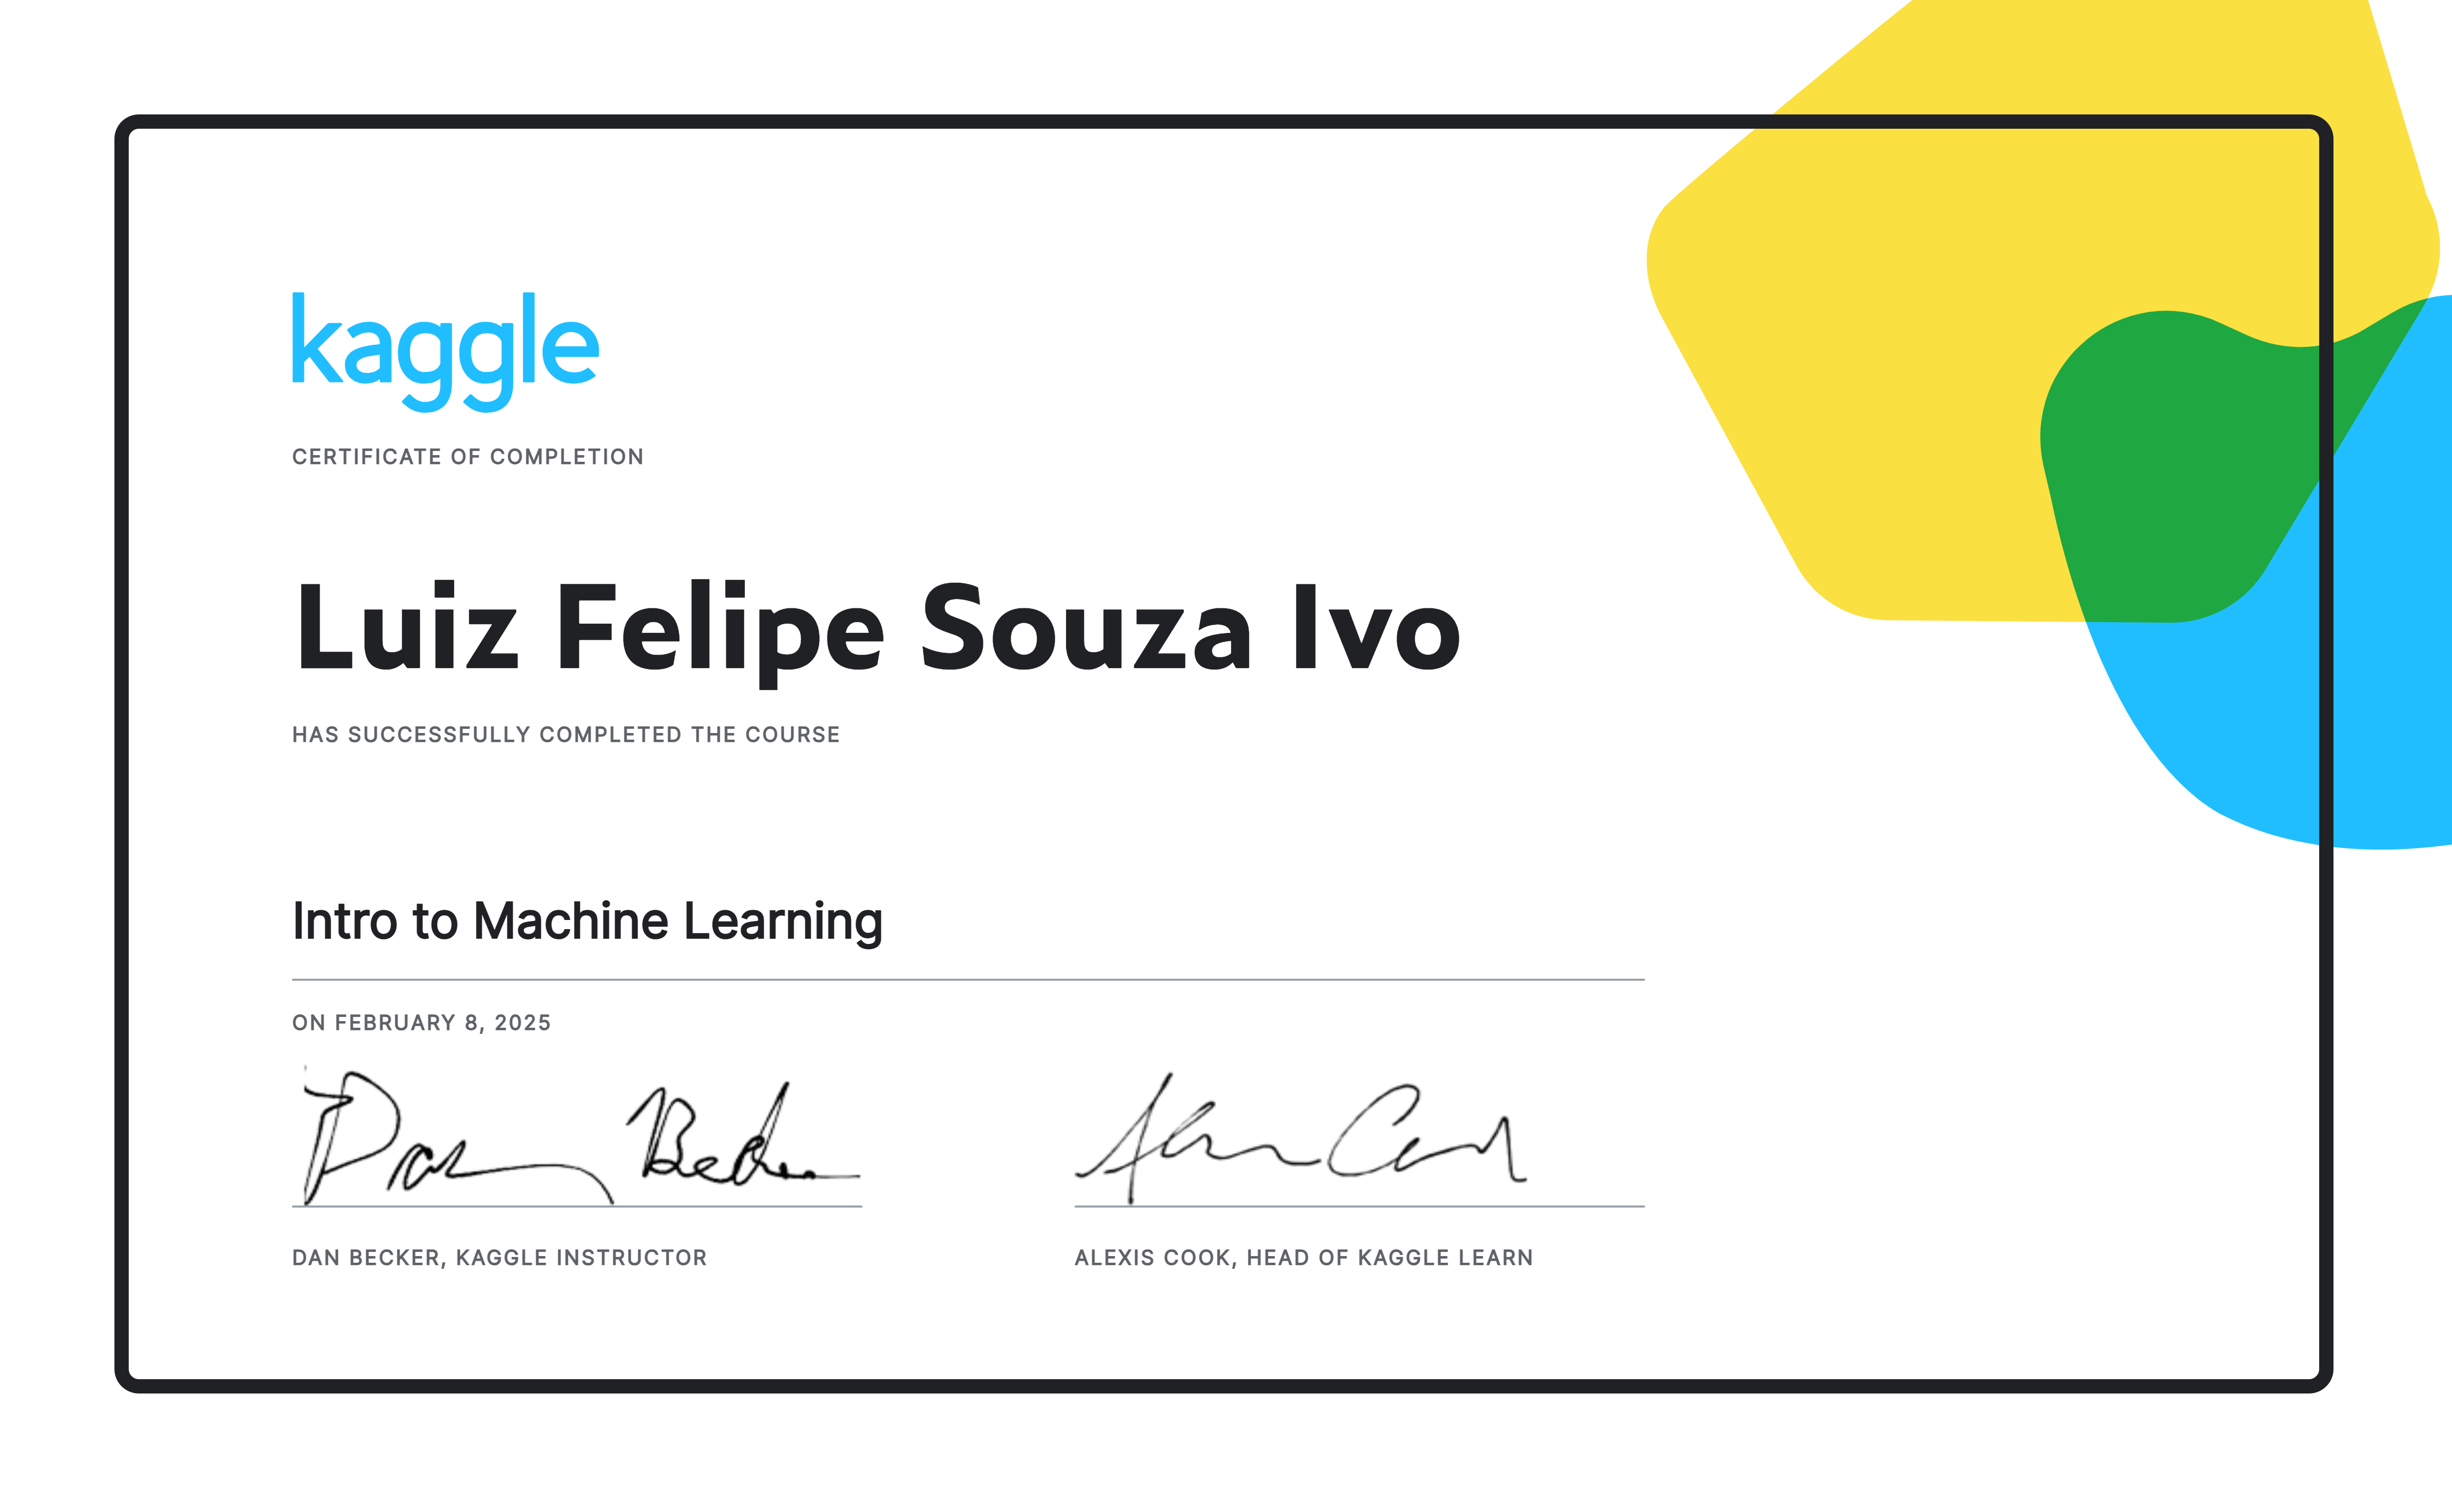

LINK REPOSITÓRIO GIT HUB = https://github.com/luizfelipesouzaivo/PROJETO-VINHO.git